# LSTM MODEL :  미래 유동인구 예측
---

In [16]:
# 모듈 로딩
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import numpy as np
import matplotlib.pyplot as p


import random
random.seed(42)

import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic')

## [1] 데이터 전처리
---

## [2] 모델 생성
---


데이터 과거단위 생성 함수

In [31]:
# [ 학습 단위 생성 함수 ]
# data = 사용할 데이터
# n = 학습할 과거 데이터 수
# --> 예측값 개수 : 전체 데이터 갯수 - n (앞쪽데이터 n개가 제외됨)

def generateX(data, n): # data, n=5(예시)
    x_train = []
    y_train = []
    final_test = []
    for i in range(len(data)): # i = 0~9 
        x = data[i:(i + n)] # x : 0~4,1~5,2~6,3~7,4~8,5~9...9~14
        if (i + n) < len(data): # target data가 있는 범위까지만
            x_train.append(x) # x_train = 0~4,1~5,2~6,3~7,4~8까지
            y_train.append(data[i + n]) # y_train = 5,6,7,8,9
        elif (i + n) == len(data): # ** 데이터에 없는 실제 미래 값 예측하기 위한 학습 데이터 ** 
            final_test.append(x)
        else:
            break
    return np.array(x_train), np.array(y_train), np.array(final_test)
    # x_train 개수: date개수 - n(뒤)
    # y_train 개수: date개수 - n(앞)

In [55]:
def pred_future(DATA,WINDOW_SIZE,TEST_SIZE):
    
    print(f'과거 학습 단위  : {WINDOW_SIZE}시간')
    print(f'테스트 단위     : 마지막 1일 ({TEST_SIZE})')
    print(f'최종 예측       : 데이터 이후 1시간')
    print('--------------------------------')
    # [ 과거데이터 학습 단위 설정]
    x, y, z = generateX(DATA, WINDOW_SIZE) 

    print('[ before reshape ]')
    print('x.shape:',x.shape)
    print('y.shape:',y.shape)
    print('--------------------------------')
    
    # 차원 하나씩 추가 -----------------------------------------------------
    x = x.reshape(-1,WINDOW_SIZE,1)
    y = y.reshape(-1,1)
    z = z.reshape(-1,WINDOW_SIZE,1)

    print('[ after reshape ]')
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)
    print('--------------------------------')

    # [ 학습 사이즈 ] -> train, test 
    # train_size = len(DATA)-(2*WINDOW_SIZE)

    # 학습용 데이터와 시험용 데이터
    x_train = x[:-TEST_SIZE, :, :]
    y_train = y[:-TEST_SIZE, :]
    x_test = x[-TEST_SIZE:, :, :]
    y_test = y[-TEST_SIZE:, :]

    print('x_train.shape:', x_train.shape,'y_train.shape:', y_train.shape)
    print('x_test.shape :', x_test.shape, 'y_test.shape :', y_test.shape)
    print('--------------------------------')

    # 모델 구성 ---------------------------------------------------------------
    model = Sequential()
    model.add(LSTM(16, 
                input_shape=(x_train.shape[1], x_train.shape[2]), 
                activation='relu', 
                return_sequences=False)
            )

    model.add(Dense(1))
    
    # 모델 컴파일 --------------------------------------------------------------
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10)

    history = model.fit(x_train, y_train, 
                                    epochs=50, 
                                    batch_size=16,
                                    validation_split=0.2)
                                    # callbacks=[early_stop])
    
    y_hat = model.predict(x_test)

    #RECENTLY_DAYS_7 = DATA[-7:]
    #RECENTLY_DAYS_7 = RECENTLY_DAYS_7.reshape(-1,WINDOW_SIZE,1)
    pred_hour = model.predict(z)

    # 모델 저장
    # model.save('model_population.h5')

    # 예측 결과 시각화 ----------------------------------------------------------
    a_axis = np.arange(0, len(y_train))
    b_axis = np.arange(len(y_train), len(y_train) + len(y_hat))
    c_axis = np.arange(len(y_train) + len(y_hat),len(y_train) + len(y_hat) + 1 )

    plt.figure(figsize=(16,9)) 
    #plt.plot(a_axis, y_train.reshape(x_train.shape[0],))  # 학습범위
    plt.plot(b_axis, y_hat.reshape(x_test.shape[0],),'-o', color='red', label='Predicted') # 테스트 정답
    plt.plot(b_axis, y_test.reshape(x_test.shape[0],),'-o', color='green', alpha=0.5, label='Actual') # 테스트 예측
    plt.plot(c_axis, pred_hour.reshape(z.shape[0],),'-^', color='blue', label='Future') # ** 데이터 이후 예측값1 **
    
    plt.legend()
    plt.show()

    return z

과거 학습 단위  : 7시간
테스트 단위     : 마지막 24일(24시간)
최종 예측       : 데이터 이후 1시간
--------------------------------
[ before reshape ]
x.shape: (8753, 7)
y.shape: (8753,)
--------------------------------
[ after reshape ]
x.shape: (8753, 7, 1)
y.shape: (8753, 1)
--------------------------------
x_train.shape: (8729, 7, 1) y_train.shape: (8729, 1)
x_test.shape : (24, 7, 1) y_test.shape : (24, 1)
--------------------------------
Epoch 1/50
437/437 [==============================] - 2s 3ms/step - loss: 29174726.0000 - val_loss: 4256104.5000
Epoch 2/50
437/437 [==============================] - 1s 2ms/step - loss: 4778114.0000 - val_loss: 3851246.7500
Epoch 3/50
437/437 [==============================] - 1s 2ms/step - loss: 3349469.5000 - val_loss: 3647775.5000
Epoch 4/50
437/437 [==============================] - 1s 2ms/step - loss: 4054167.7500 - val_loss: 2337522.0000
Epoch 5/50
437/437 [==============================] - 1s 2ms/step - loss: 2463738.2500 - val_loss: 1521868.0000
Epoch 6/50
437/437 [===

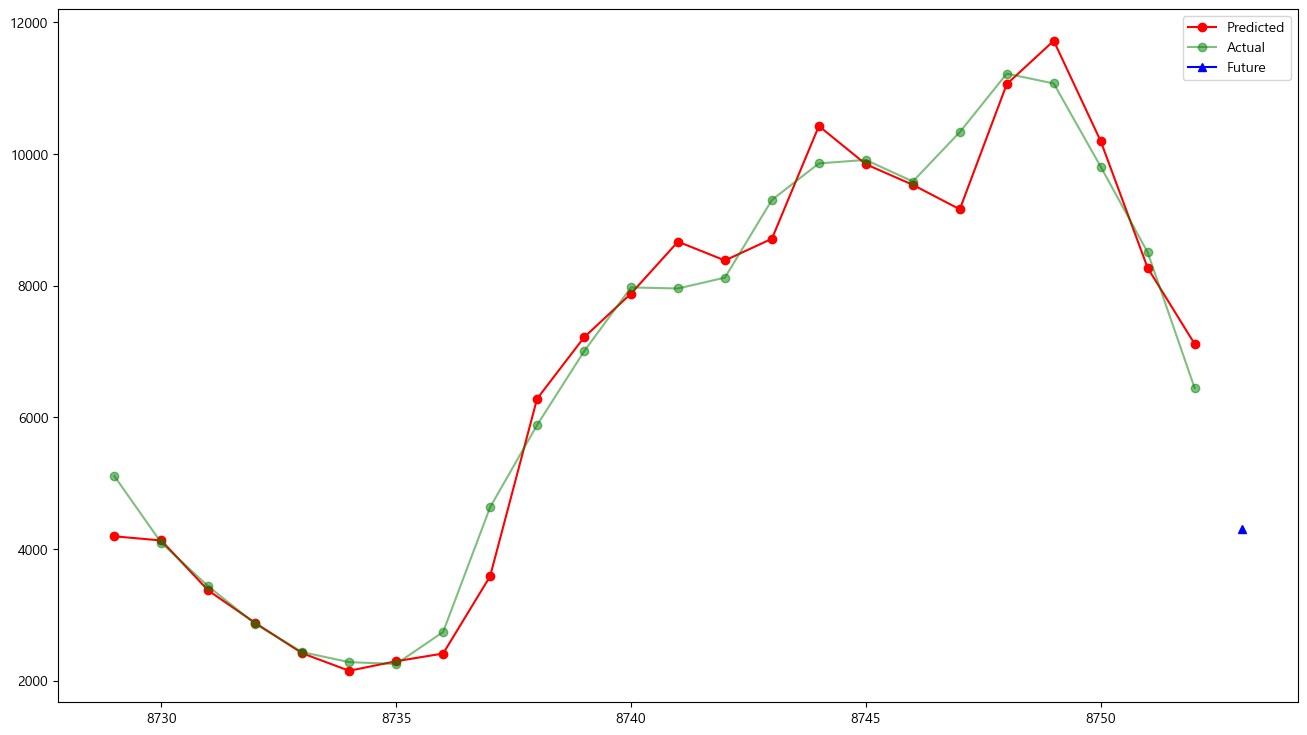

In [56]:
# 미래 예측 함수 테스트(sin 그래프)

# [ 조정 변수]

# 총 데이터
# DATA = np.sin(2 * np.pi * 0.03 * np.arange(0, 300)) + np.random.random(300) # Sine 함수에 노이즈를 섞은 데이터로 학습 데이터 100개를 생성한다
df = pd.read_csv("../data/data.csv")
df = df.iloc[:,-240:]
DATA = df["values"]

# 과거 학습 단위 = 예측하게 되는 타겟 갯수
WINDOW_SIZE = 7

# 테스트 사이즈 설정
TEST_SIZE = 24

# past_learn: 과거 학습할 데이터 단위 
pred = pred_future(DATA,WINDOW_SIZE,TEST_SIZE)

In [52]:
# 최근 7시간 : 데이터 마지막 7시간
pred

array([[[ 9581],
        [10331],
        [11220],
        [11070],
        [ 9806],
        [ 8504],
        [ 6443]]], dtype=int64)

In [24]:
# 최근 7시간 : 데이터 마지막 7시간
RECENTLY_7HOURS = DATA[-7:]
RECENTLY_7HOURS

8753     9581
8754    10331
8755    11220
8756    11070
8757     9806
8758     8504
8759     6443
Name: values, dtype: int64